## Code to compare the performance of QuakeFlow to conventional catalogs

Goals for this code:

1) Compare picks. For positive matches, calculate mean residual and standard deviation of residuals. Also calculate false positives and false negatives, to yield precision, recall, and F1-score. *TO-DO: decide how to evaluate new picks from PhaseNet that might be correct!

2) TO-DO: Compare association. For earthquakes that match, compare their locations and number of picks and which stations had picks. 

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load in results from QuakeFlow from a response json file:

In [3]:
load_file = 'result_example'

In [17]:
f = open(load_file+'.json')
result = json.load(f)

catalog_gamma = result["catalog"]
picks_gamma = result["picks"]
df = pd.DataFrame(picks_gamma)
df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
df.head()

id               timestamp      prob       amp type  event_idx  \
0  XO.LA34..HH 2018-05-25 12:36:54.173  0.425698  0.000007    p         -1   
1  XO.LT02..HH 2018-05-25 12:36:33.493  0.348446  0.000033    s         -1   
2  XO.LA28..HH 2018-05-25 12:37:18.294  0.695857  0.000015    p         -1   
3  XO.LT11..HH 2018-05-25 12:37:25.334  0.588539  0.000013    p         -1   
4  XO.LD36..HH 2018-05-25 12:38:27.393  0.459930  0.000014    p         -1   

   prob_gmma  
0         -1  
1         -1  
2         -1  
3         -1  
4         -1

#### Load in the original catalog information:

In [30]:
# Load master pick list
ground_truth = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_picks.parquet')

In [31]:
ground_truth['og_timestamp']=pd.to_datetime(ground_truth['og_timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')


In [32]:
ground_truth.head()

og_phase  arr_id     sta_code  pick_id            og_timestamp og_channel
0        s     125  XO.EP15..HH      125 2018-12-01 13:45:47.290        HHN
1        s     125   AV.PVV..SH      125 2019-06-01 09:36:36.644        SHZ
2        s     125  AK.FALS..BH      125 2019-01-01 05:06:32.877        BHN
3        s     125  XO.WD61..HH      125 2019-07-01 04:05:37.933        HHZ
4        s     125  AV.Q18K..BH      125 2018-07-01 02:36:30.270        BHZ

## Let's compare picks between PhaseNet and the original catalog.

#### Now, see which picks are true positives by joining based on phase type, station code, and time residual within a threshold.

In [49]:
resid_max = 2 # seconds

# Let's only compare the part of the original catalog that we have PhaseNet picks for:
cat_start = min(df['timestamp'] - pd.Timedelta(30,'seconds'))
cat_end = max(df['timestamp'] + pd.Timedelta(30,'seconds'))
ground_truth = ground_truth[(ground_truth['og_timestamp'] > cat_start) & (ground_truth['og_timestamp'] < cat_end)]

# Sort both dataframes by time:
df.sort_values(by=['timestamp'],inplace=True)
ground_truth.sort_values(by=['og_timestamp'],inplace=True)

# Merge dataframes, only merging picks if they have matching station ID, 
# phase type, and are within 0.1 s of each other
comp = pd.merge_asof(left=df,right=ground_truth,left_on=['timestamp'],right_on=['og_timestamp'],left_by=['id','type'],right_by=['sta_code','og_phase'],tolerance = pd.Timedelta(resid_max,'seconds'),direction='nearest')

# Add residual column: 
comp['pick_resid'] = comp['og_timestamp'] - comp['timestamp']
comp['pick_resid'] = comp['pick_resid'].dt.total_seconds()

In [34]:
comp

id               timestamp      prob       amp type  event_idx  \
0    XO.LT02..HH 2018-05-25 12:36:33.493  0.348446  0.000033    s         -1   
1    XO.LA34..HH 2018-05-25 12:36:54.173  0.425698  0.000007    p         -1   
2    XO.LA28..HH 2018-05-25 12:37:18.294  0.695857  0.000015    p         -1   
3    XO.LT11..HH 2018-05-25 12:37:25.334  0.588539  0.000013    p         -1   
4    XO.LD36..HH 2018-05-25 12:38:27.393  0.459930  0.000014    p         -1   
..           ...                     ...       ...       ...  ...        ...   
191  XO.LT03..HH 2018-05-25 13:34:48.626  0.652087  0.000038    s         -1   
192  XO.LT03..HH 2018-05-25 13:34:59.936  0.441690  0.000021    s         -1   
193  XO.LT03..HH 2018-05-25 13:35:12.184  0.654834  0.000040    p         -1   
194  XO.LT03..HH 2018-05-25 13:35:13.444  0.898514  0.000038    s         -1   
195  XO.LT03..HH 2018-05-25 13:36:28.684  0.931116  0.000021    p         -1   

     prob_gmma og_phase  arr_id sta_code  pick_id og_timestamp og_channel  \
0           -1      NaN     NaN      NaN      NaN          NaT        NaN   
1           -1      NaN     NaN      NaN      NaN          NaT        NaN   
2           -1      NaN     NaN      NaN      NaN          NaT        NaN   
3           -1      NaN     NaN      NaN      NaN          NaT        NaN   
4           -1      NaN     NaN      NaN      NaN          NaT        NaN   
..         ...      ...     ...      ...      ...          ...        ...   
191         -1      NaN     NaN      NaN      NaN          NaT        NaN   
192         -1      NaN     NaN      NaN      NaN          NaT        NaN   
193         -1      NaN     NaN      NaN      NaN          NaT        NaN   
194         -1      NaN     NaN      NaN      NaN          NaT        NaN   
195         -1      NaN     NaN      NaN      NaN          NaT        NaN   

     pick_resid  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
191         NaN  
192         NaN  
193         NaN  
194         NaN  
195         NaN  

[196 rows x 14 columns]

#### Use the merged dataframe to calculate performance metrics:

In [50]:
true_positives = comp['og_timestamp'].notna().sum()

false_positives = comp['og_timestamp'].isna().sum()

false_negatives = len(ground_truth)-true_positives

print('There were ' + str(true_positives) + ' true positives.')
print('There were ' + str(false_positives) + ' false positives.')
print('There were ' + str(false_negatives) + ' false negatives.')

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * ((precision * recall)/(precision + recall))

print('This yields a precision of ' + str(round(precision,2)) + ', a recall of ' + str(round(recall,2)) + ', and an F1-score of ' + str(round(f1,2)) + '.')

There were 2 true positives.
There were 194 false positives.
There were 1873 false negatives.
This yields a precision of 0.01, a recall of 0.0, and an F1-score of 0.0.


#### And residual statistics:

Mean residual was -0.61 seconds.
Residual standard deviation was 0.5 seconds.


<AxesSubplot:>

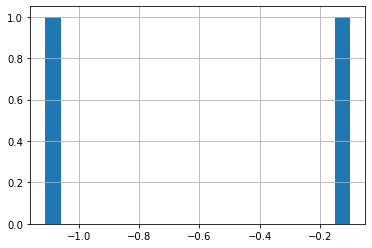

In [51]:
resid = comp['pick_resid'][comp['pick_resid'].notna()]

mean_resid = np.mean(resid)
std_resid = np.std(resid)

print('Mean residual was ' + str(round(mean_resid,2)) + ' seconds.')
print('Residual standard deviation was ' + str(round(std_resid,2)) + ' seconds.')

comp['pick_resid'].hist(bins=20)

In [36]:
resid_max = 0.1

true_positives = len(np.abs(comp['pick_resid'])<=resid_max)
false_positives = len(np.abs(comp['pick_resid'])>resid_max)
cross = pd.merge(left = df, right = ground_truth,how="outer", left_on=['id','type'],right_on=['sta_code','og_phase'])
# Picks that PhaseNet missed:
missed_picks = cross[cross['timestamp'].isna()]
false_negatives = len(missed_picks)

print('There were ' + str(true_positives) + ' true positives.')
print('There were ' + str(false_positives) + ' false positives.')
print('There were ' + str(false_negatives) + ' false negatives.')

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * ((precision * recall)/(precision + recall))

print('This yields a precision of ' + str(round(precision,2)) + ', a recall of ' + str(round(recall,2)) + ', and an F1-score of ' + str(round(f1,2)) + '.')


There were 196 true positives.
There were 196 false positives.
There were 1637 false negatives.
This yields a precision of 0.5, a recall of 0.11, and an F1-score of 0.18.


#### Make scatter plot through time of picks

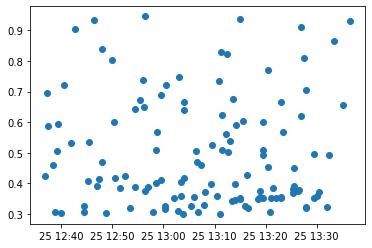

In [37]:
p_picks = df[df['type']=='p']
s_picks = df[df['type']=='p']

plt.scatter(p_picks['timestamp'],p_picks['prob'])

## Now let's take a closer look at the "new" picks that PhaseNet got, and see if they look real:



In [52]:
new_picks.iloc[2]

id                              XO.LA28..HH
timestamp       2018-05-25T12:37:18.294000Z
prob                               0.695857
amp                                0.000015
type                                      p
event_idx                                -1
prob_gmma                                -1
og_phase                                NaN
arr_id                                  NaN
sta_code                                NaN
pick_id                                 NaN
og_timestamp                            NaT
og_channel                              NaN
pick_resid                              NaN
Name: 2, dtype: object

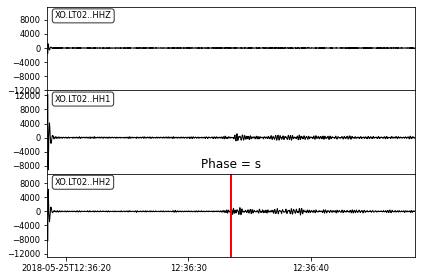

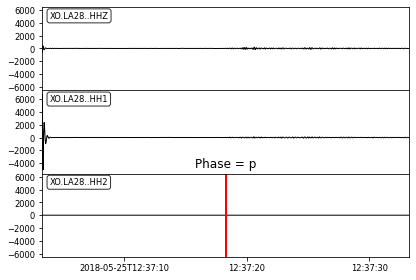

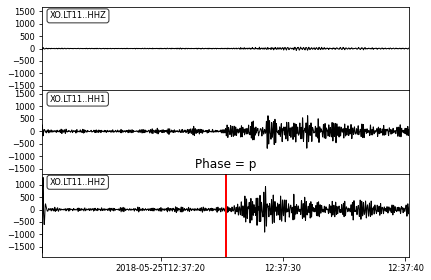

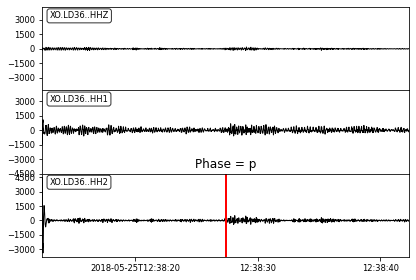

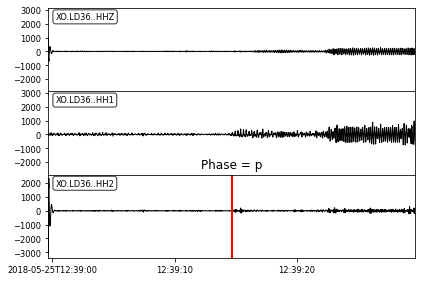

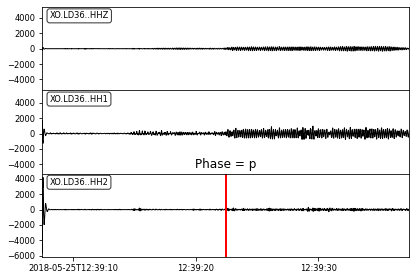

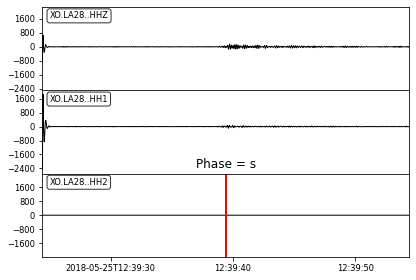

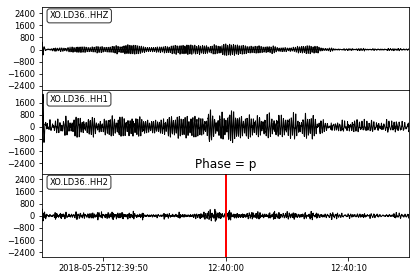

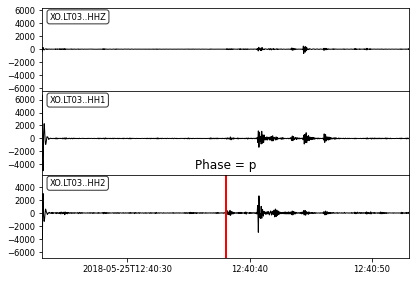

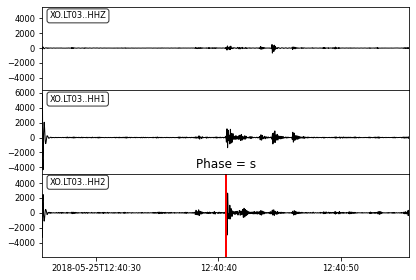

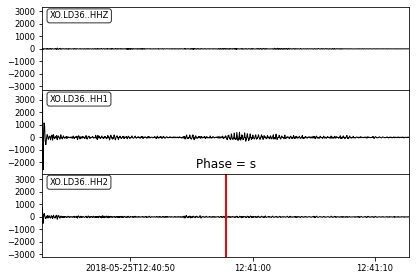

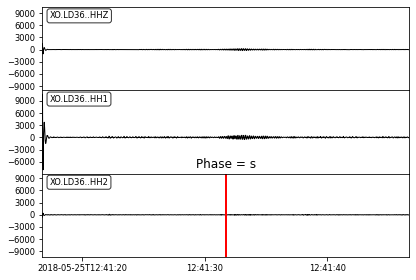

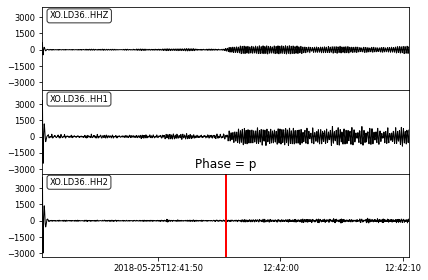

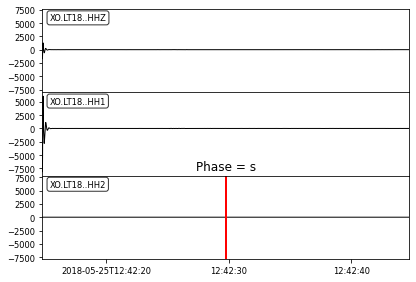

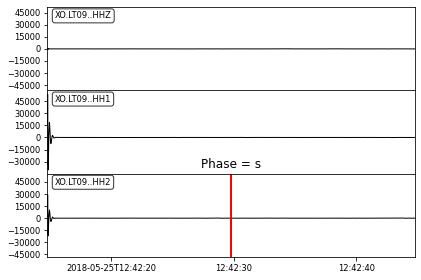

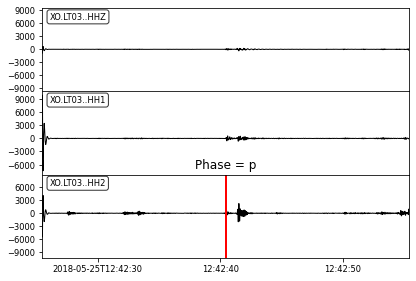

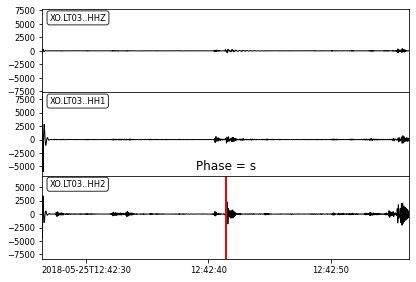

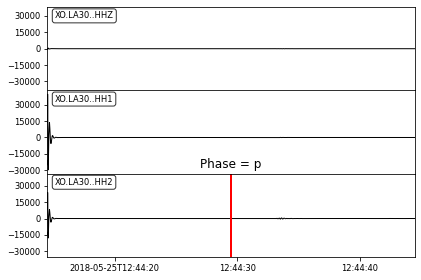

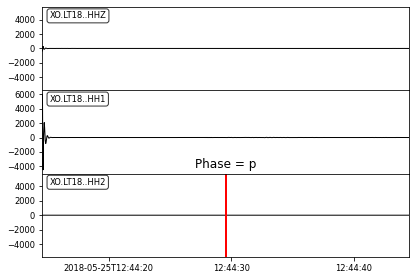

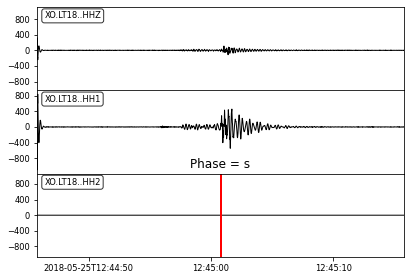

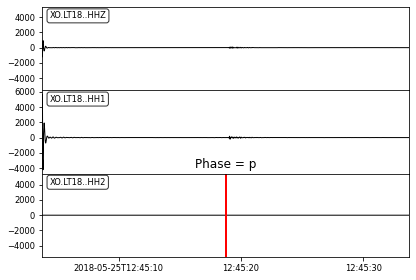

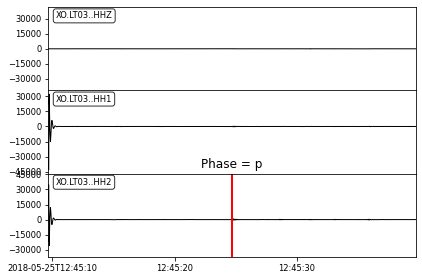

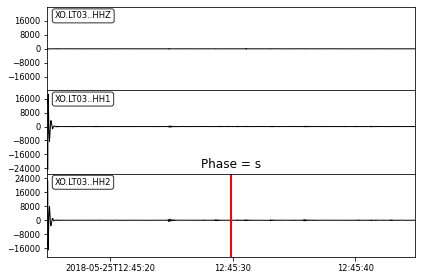

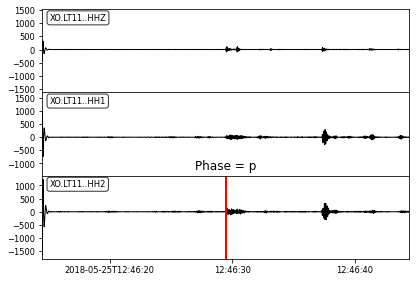

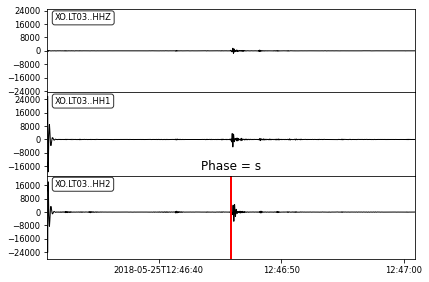

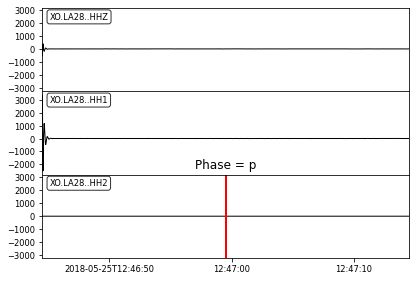

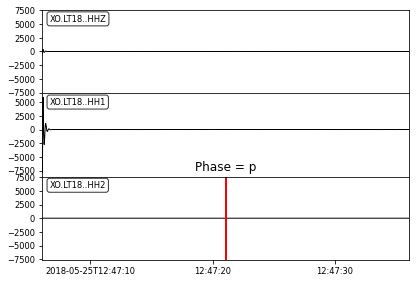

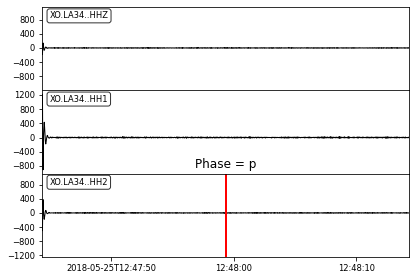

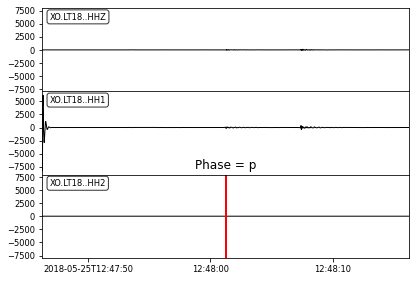

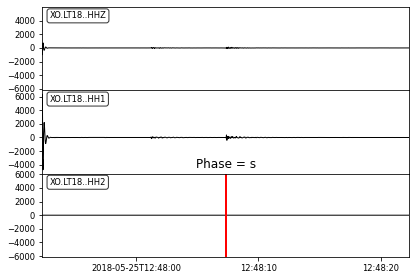

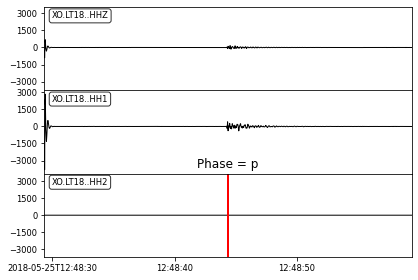

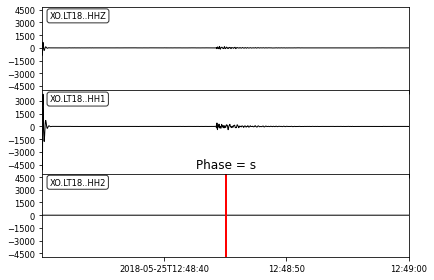

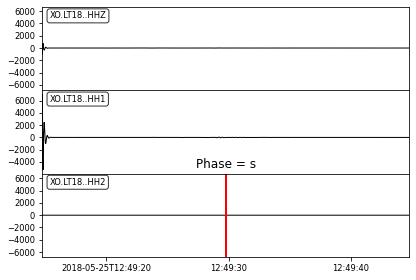

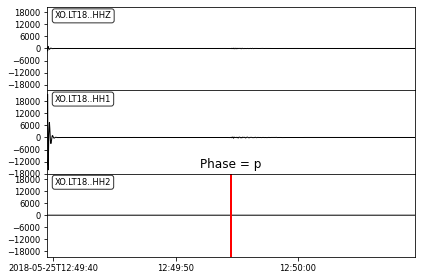

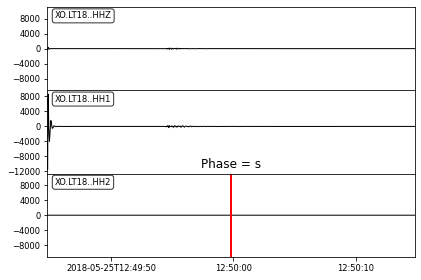

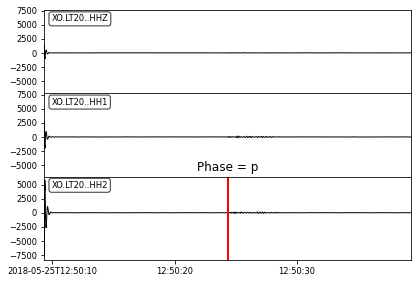

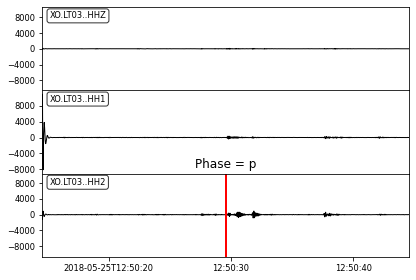

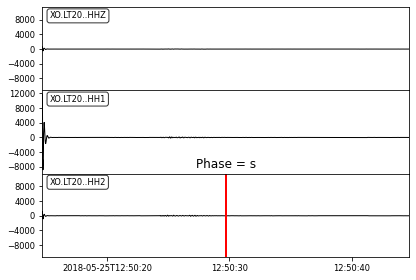

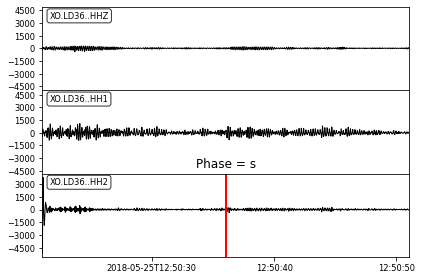

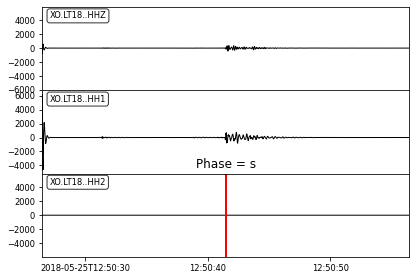

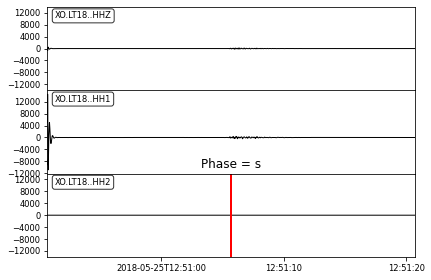

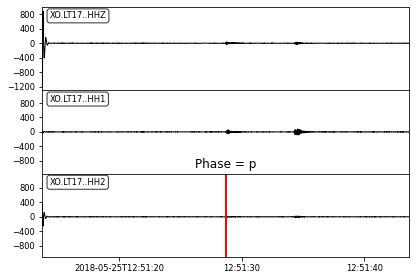

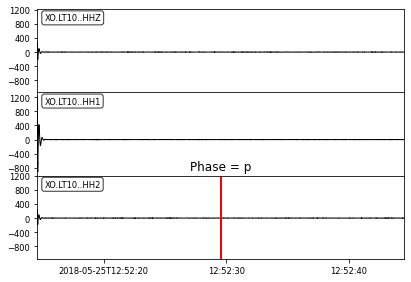

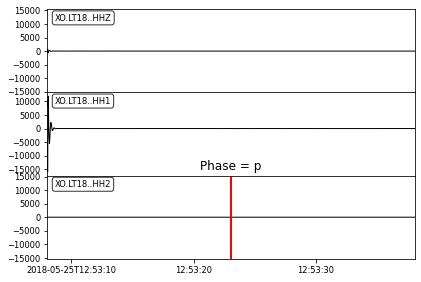

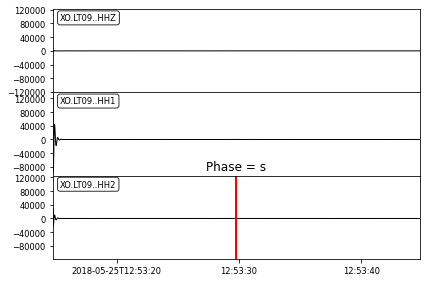

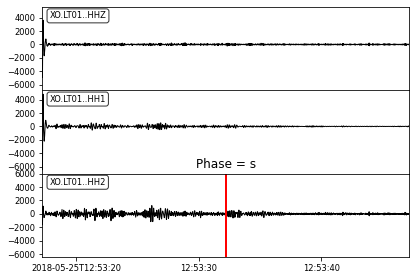

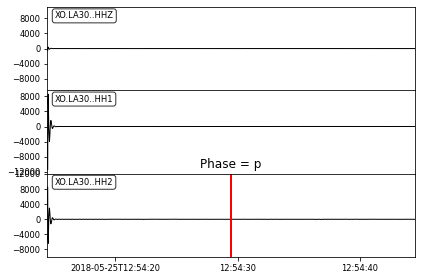

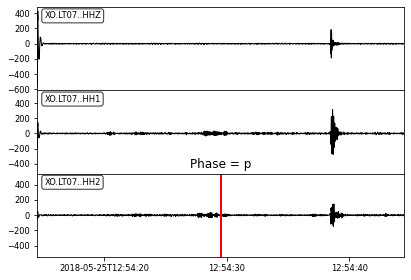

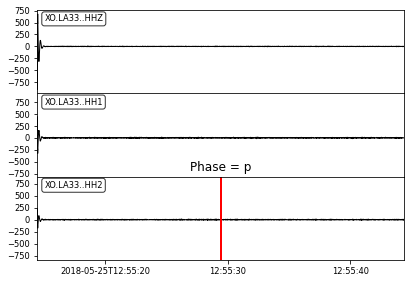

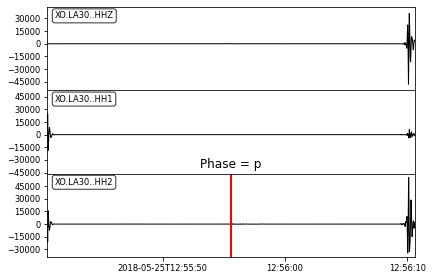

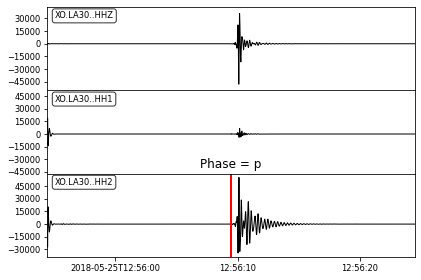

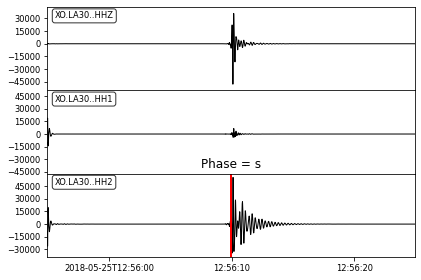

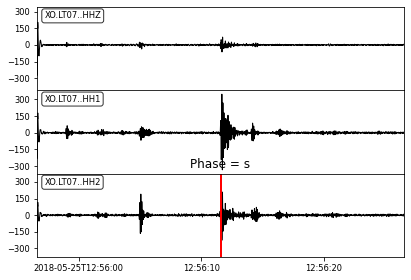

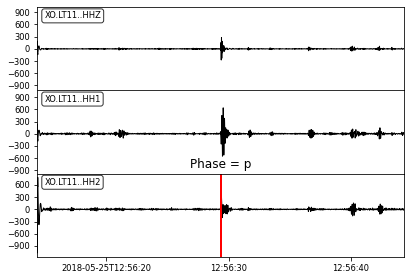

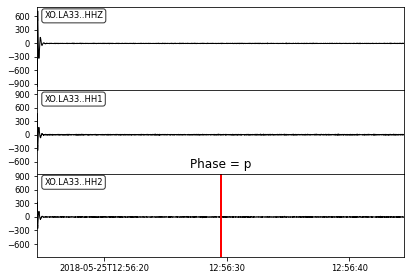

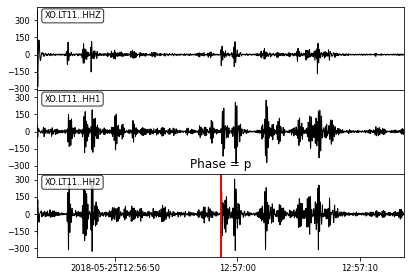

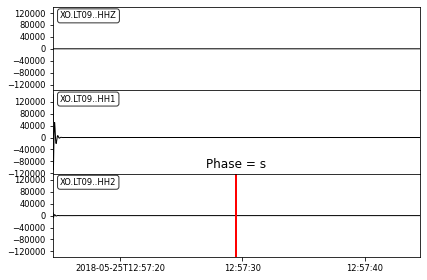

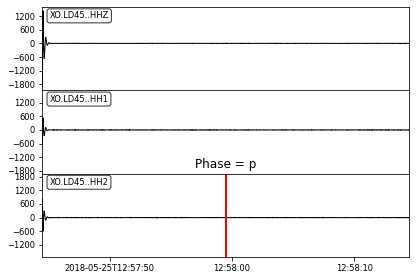

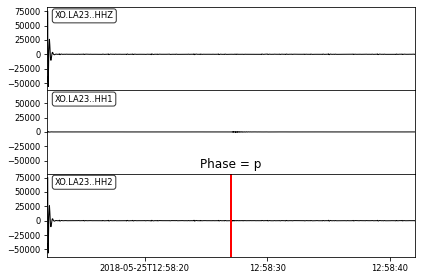

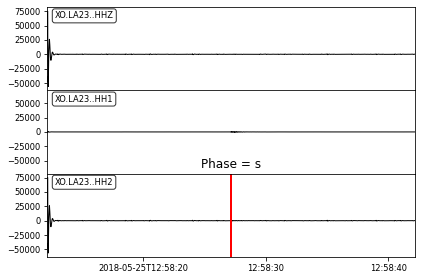

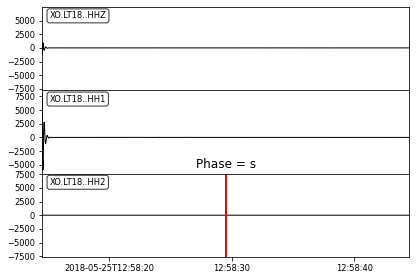

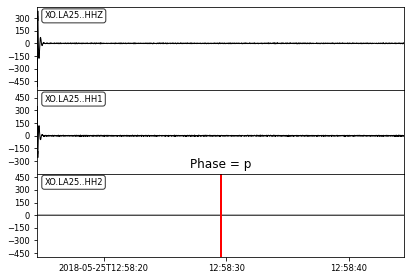

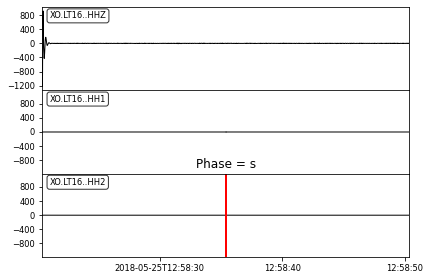

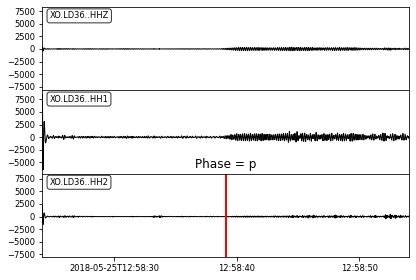

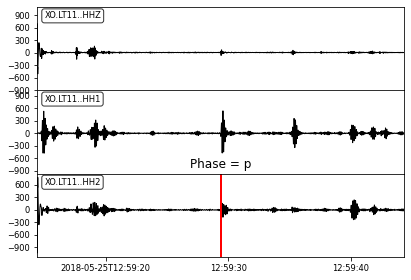

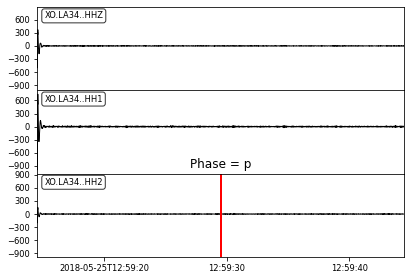

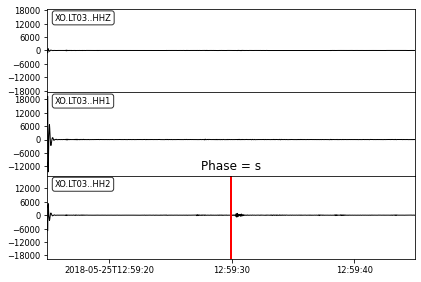

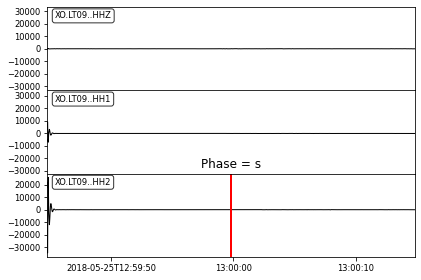

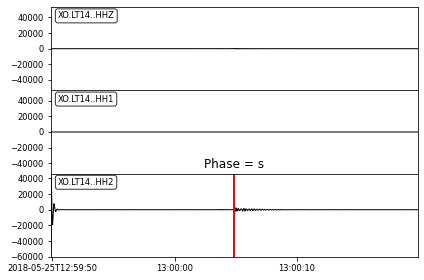

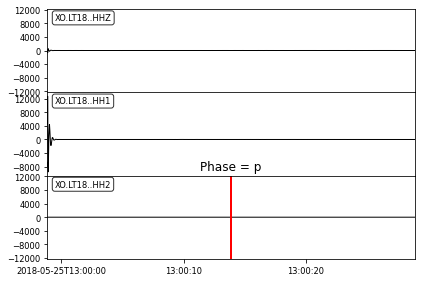

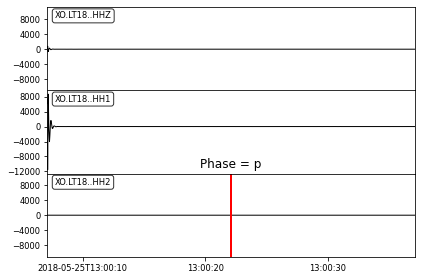

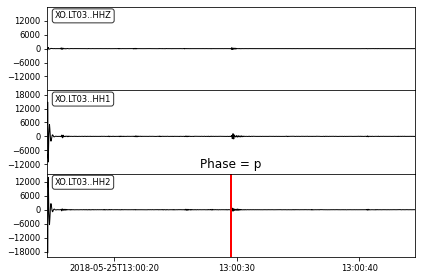

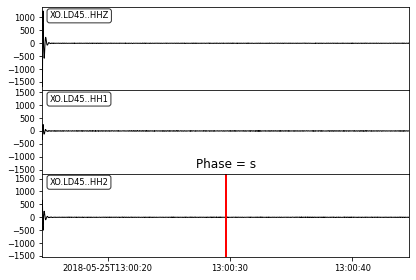

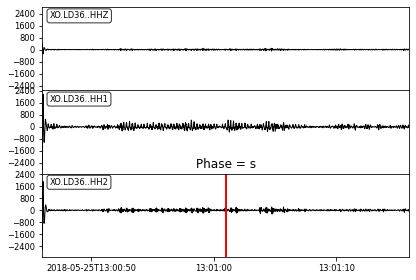

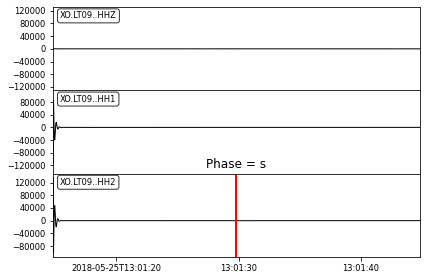

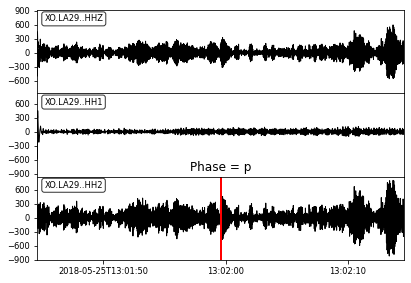

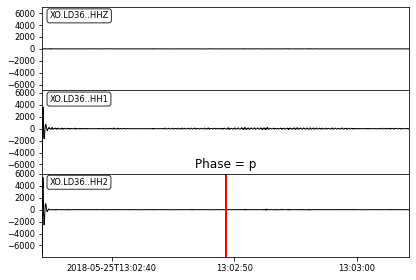

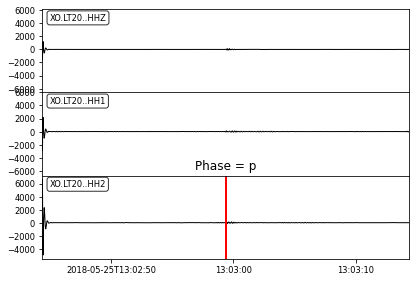

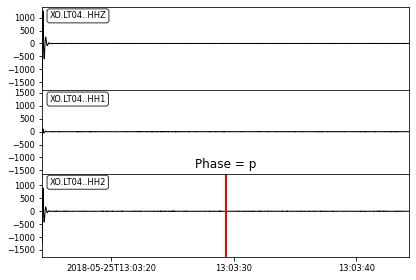

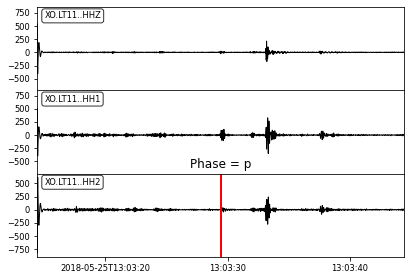

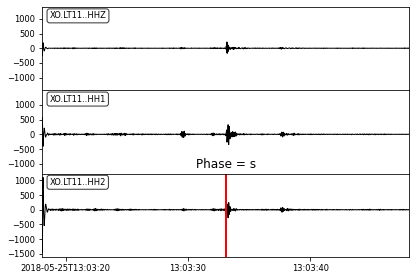

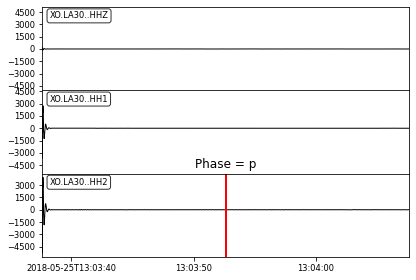

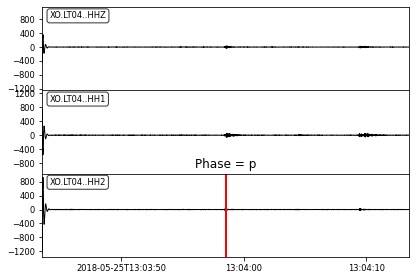

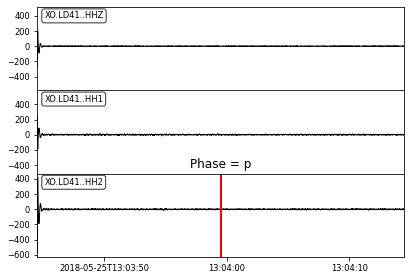

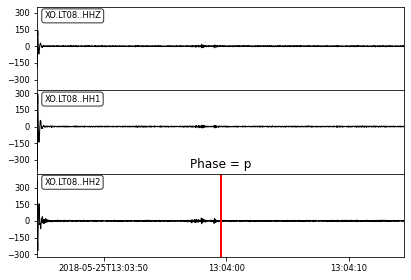

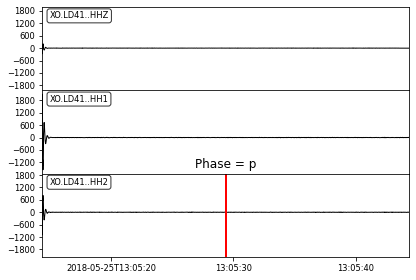

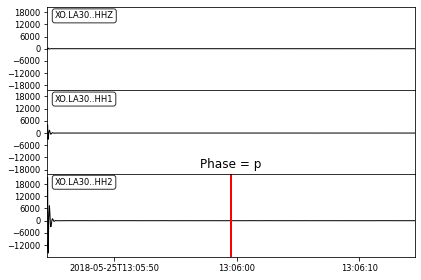

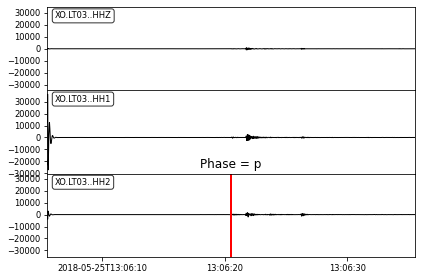

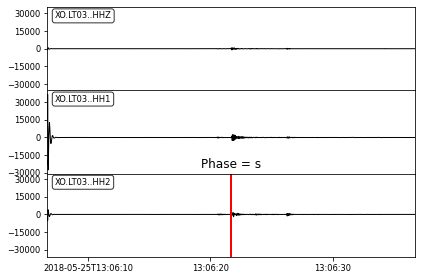

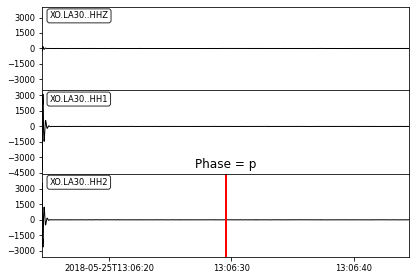

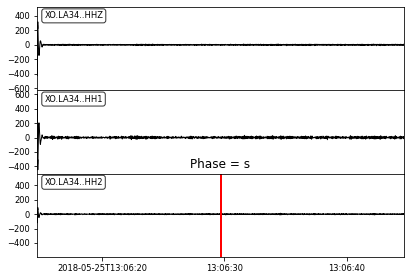

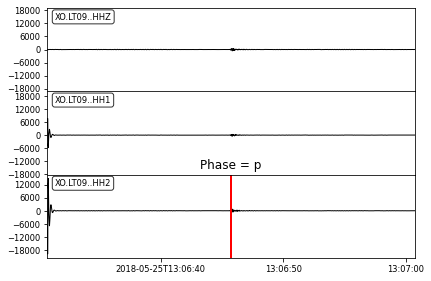

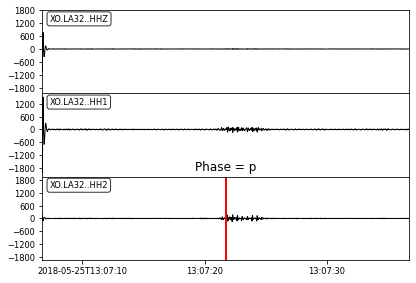

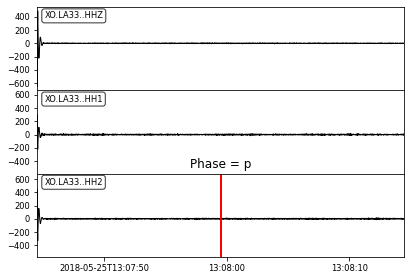

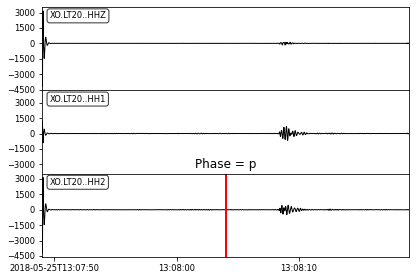

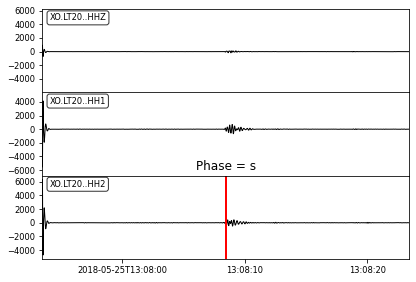

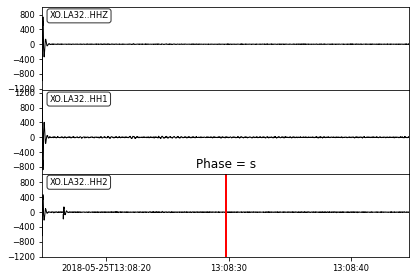

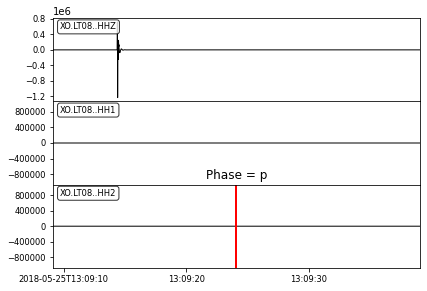

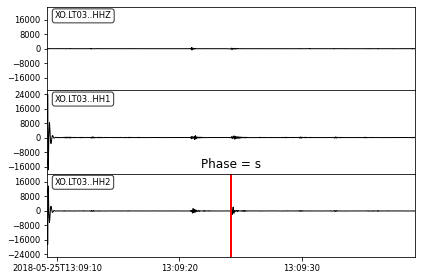

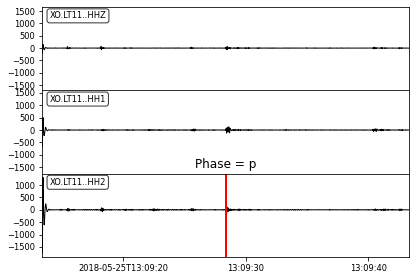

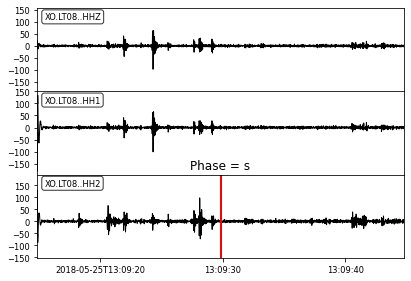

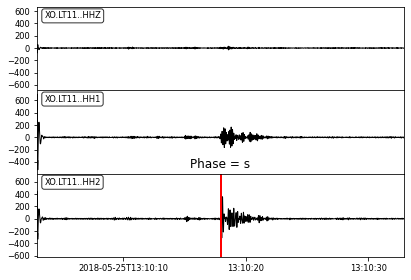

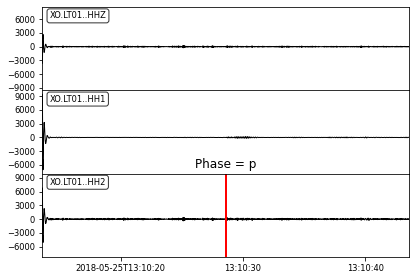

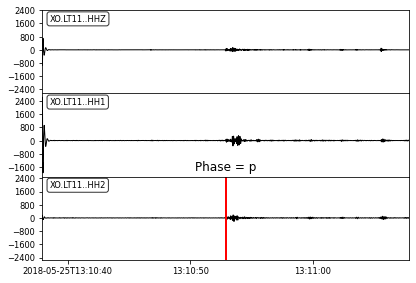

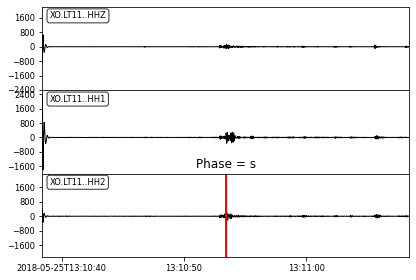

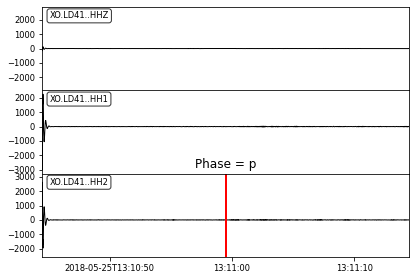

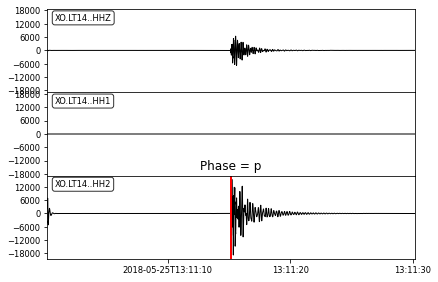

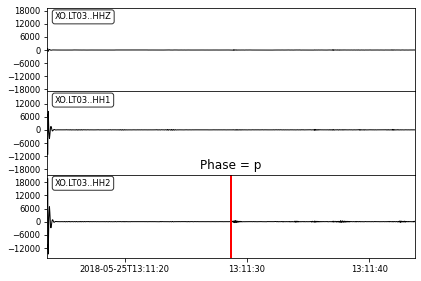

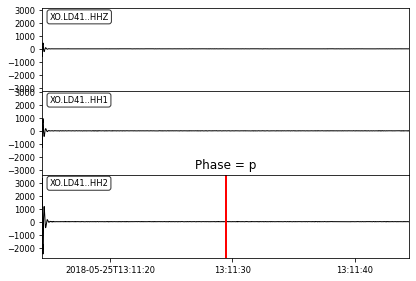

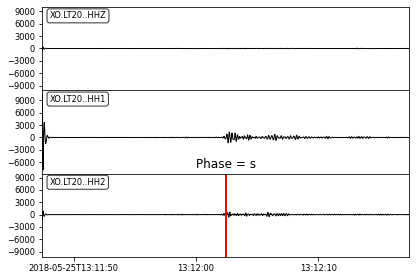

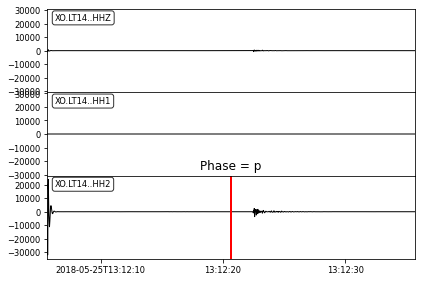

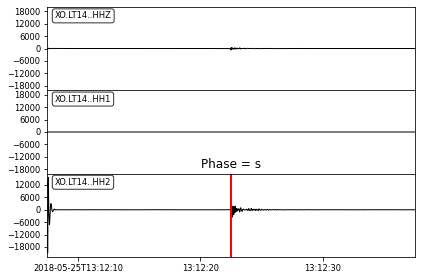

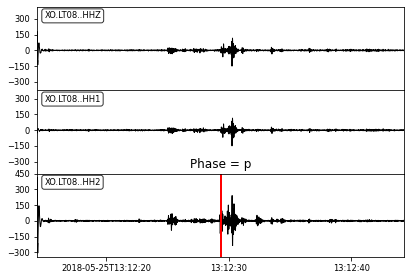

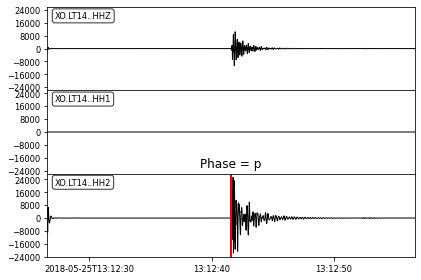

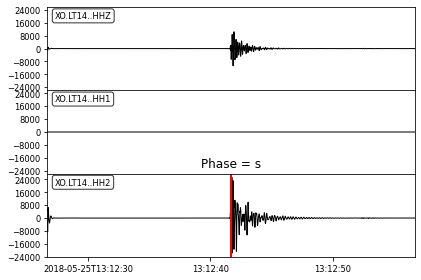

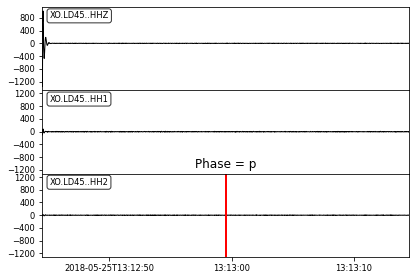

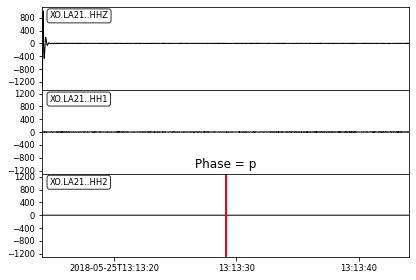

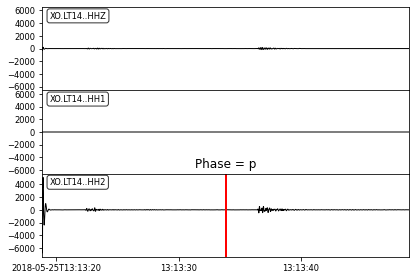

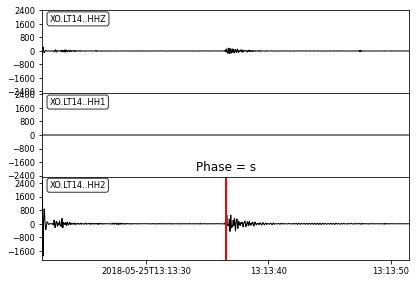

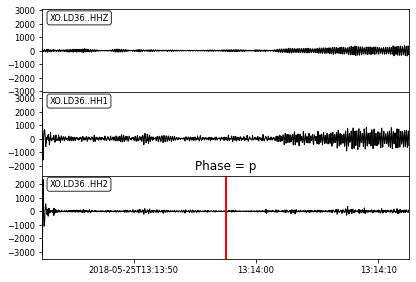

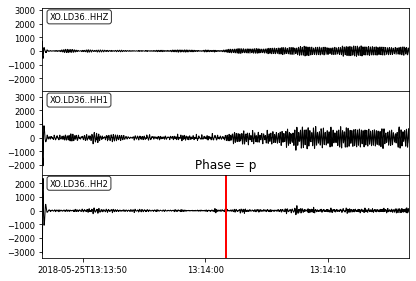

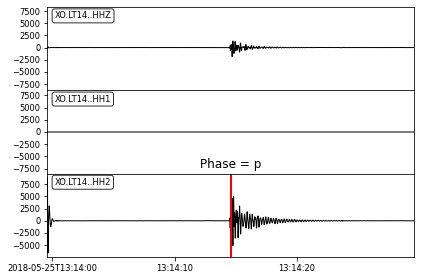

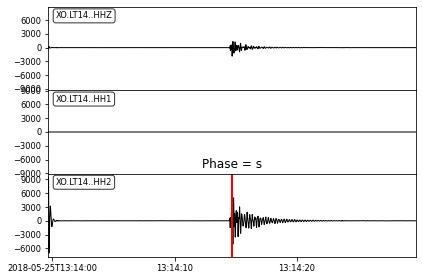

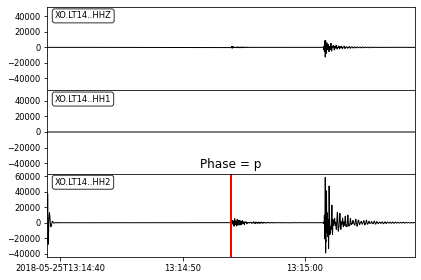

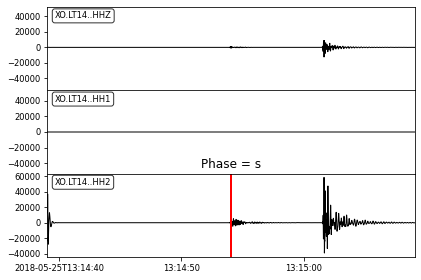

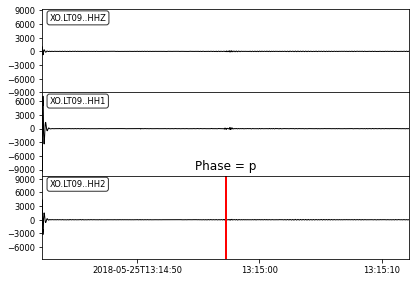

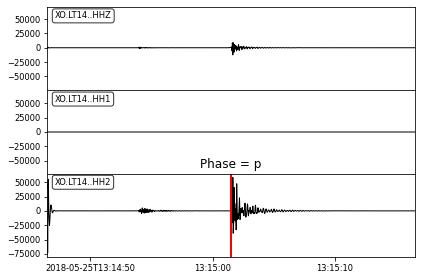

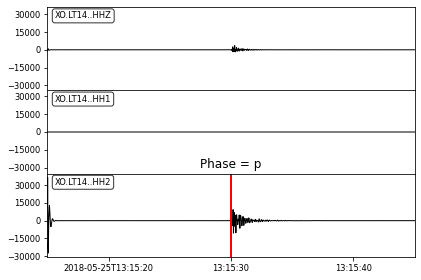

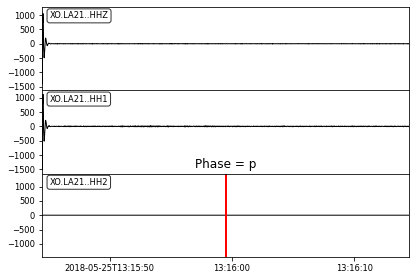

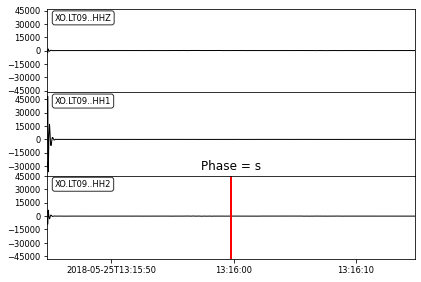

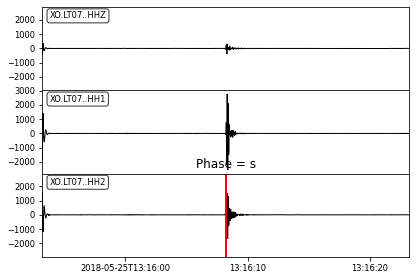

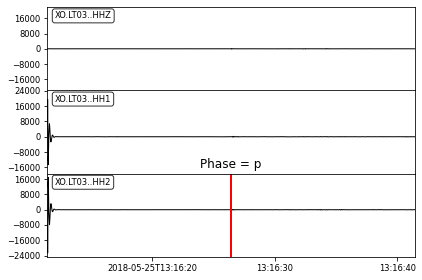

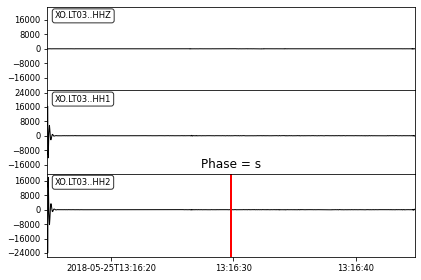

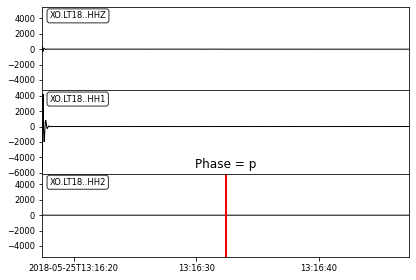

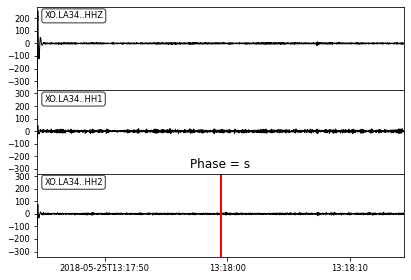

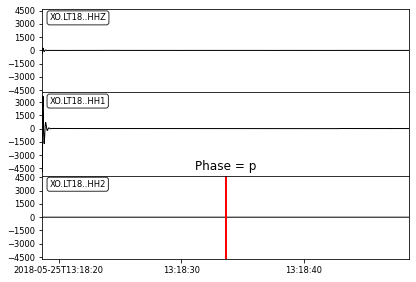

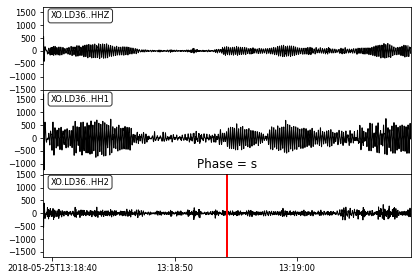

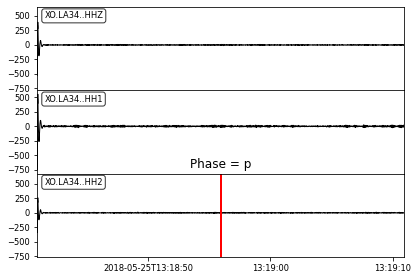

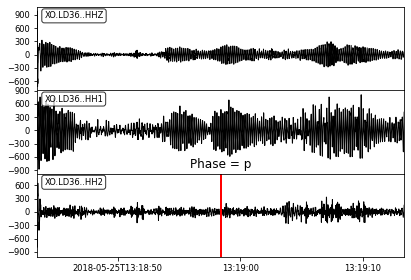

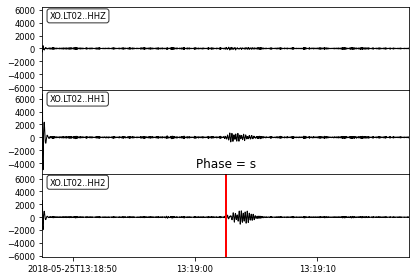

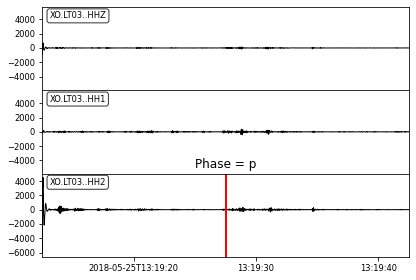

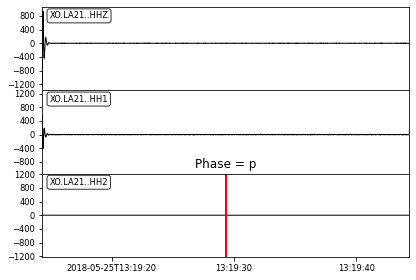

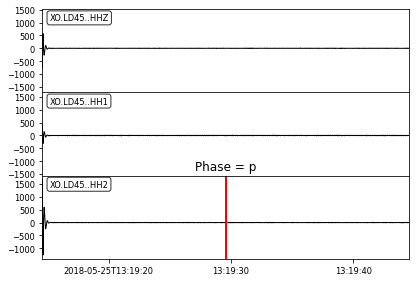

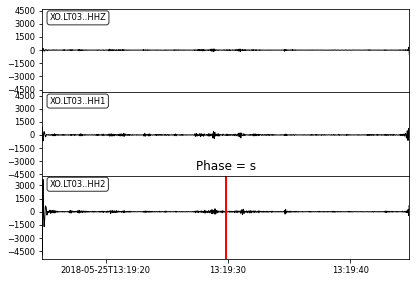

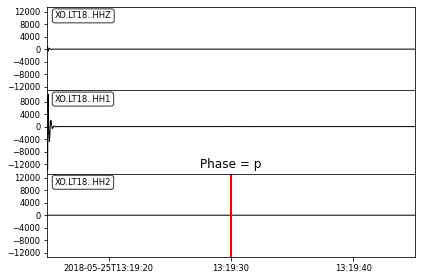

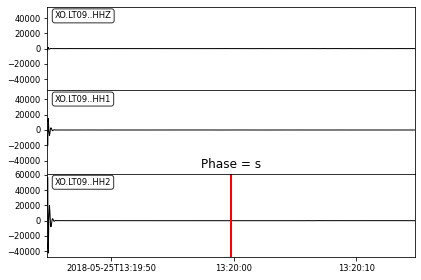

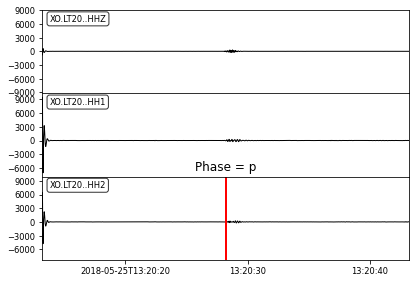

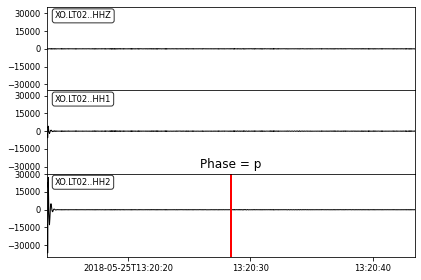

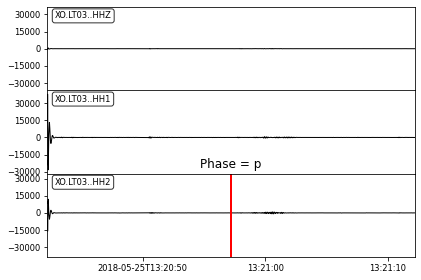

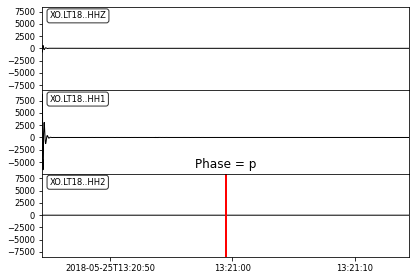

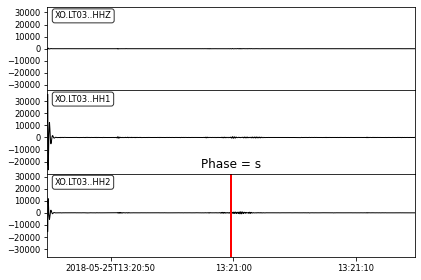

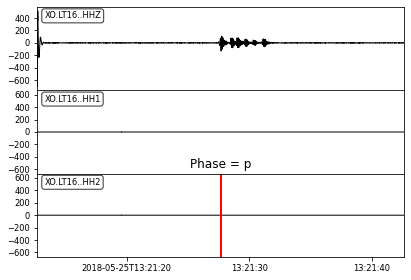

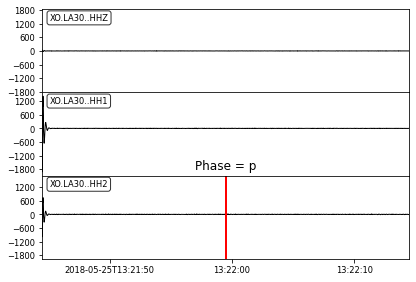

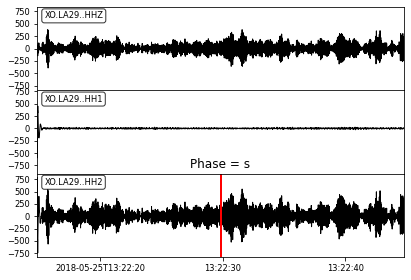

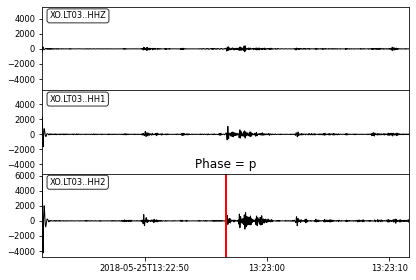

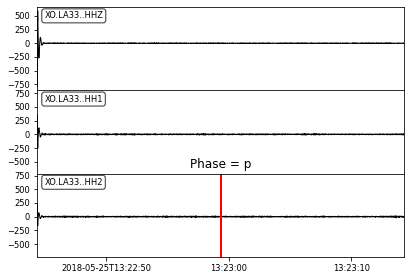

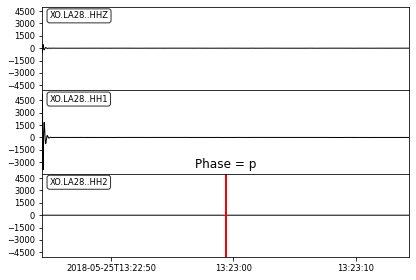

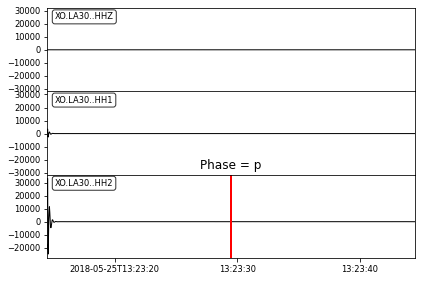

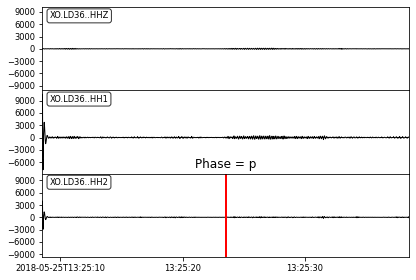

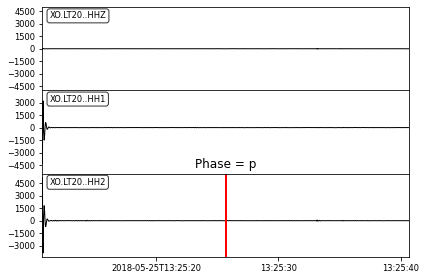

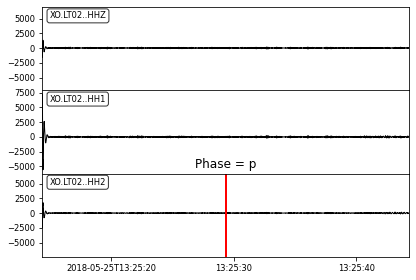

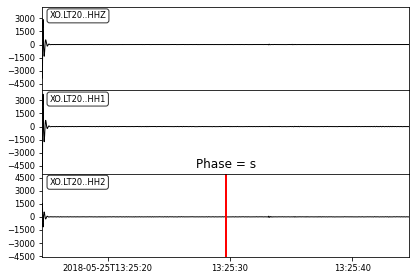

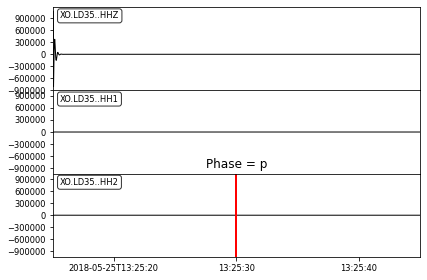

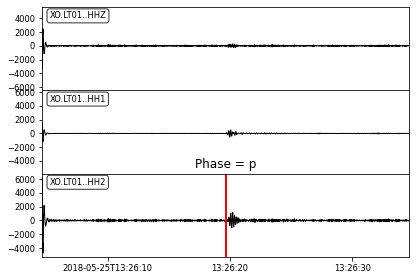

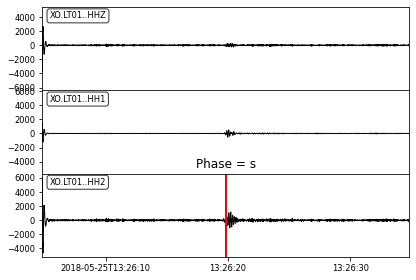

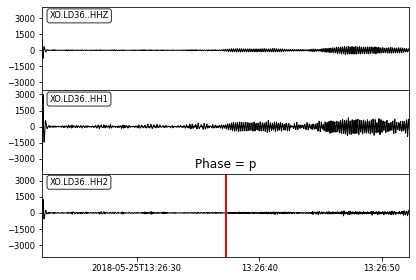

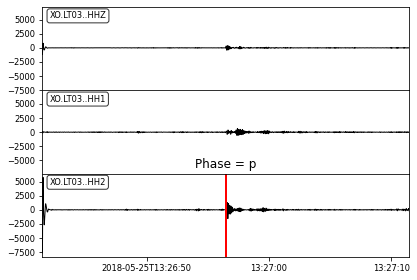

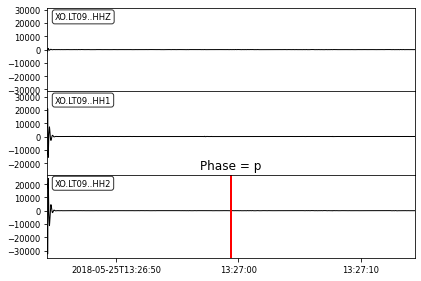

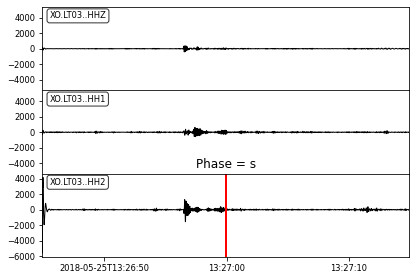

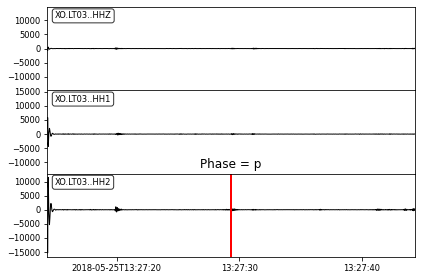

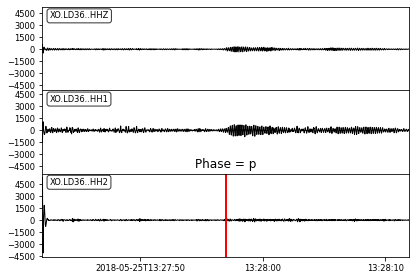

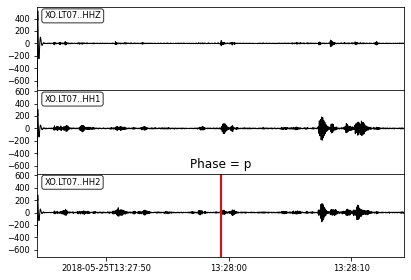

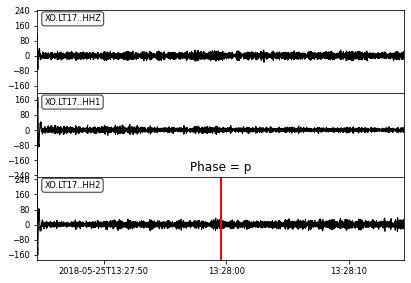

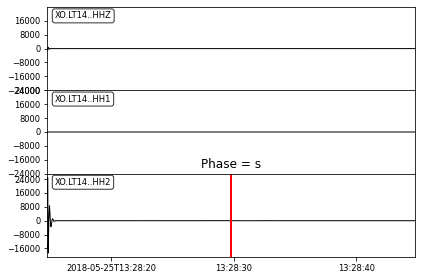

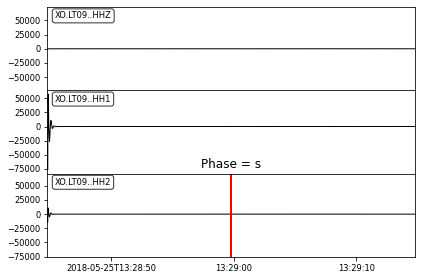

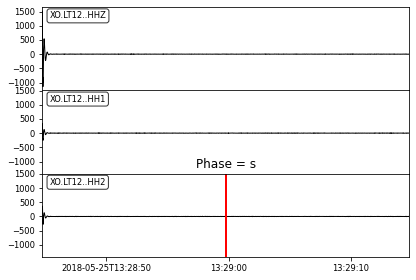

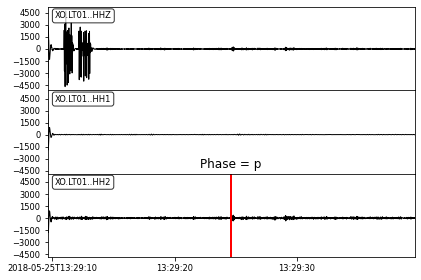

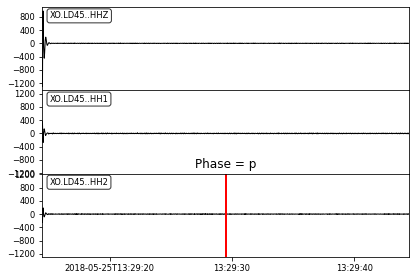

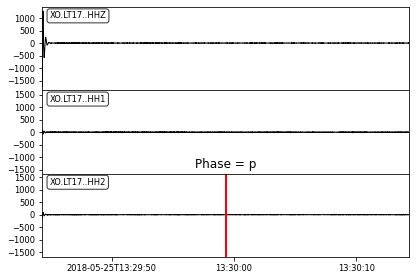

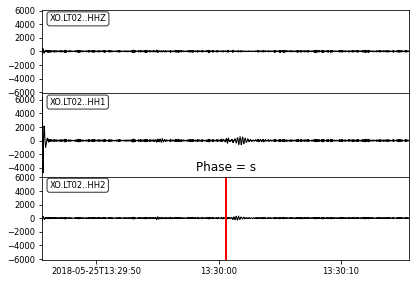

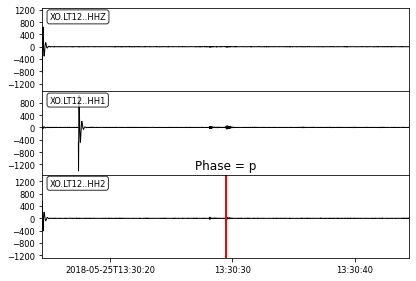

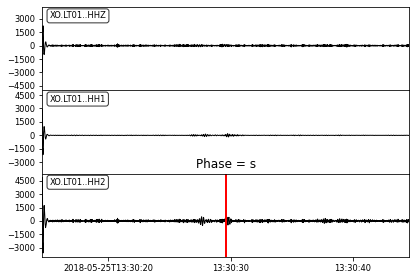

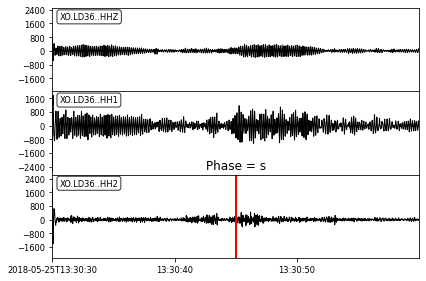

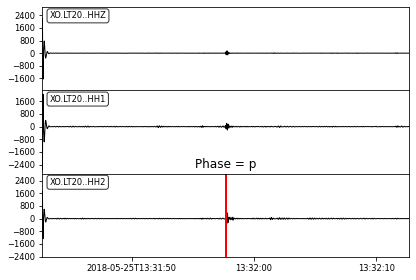

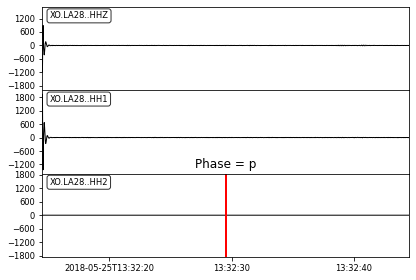

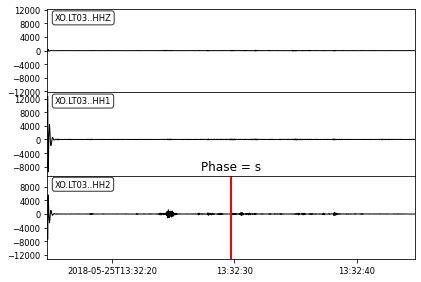

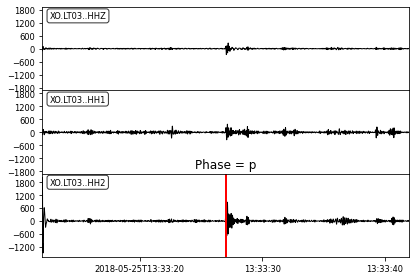

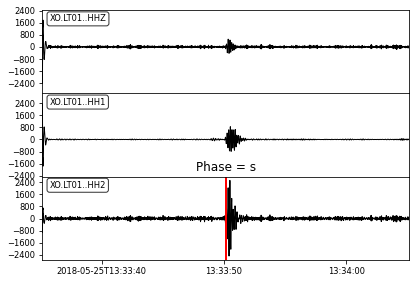

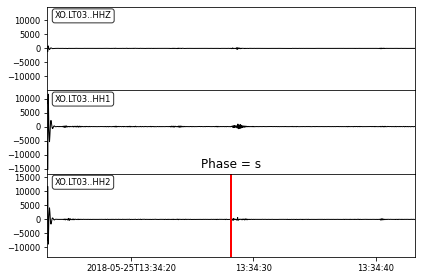

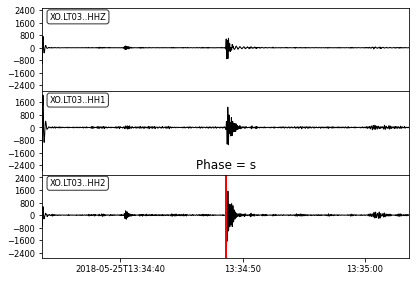

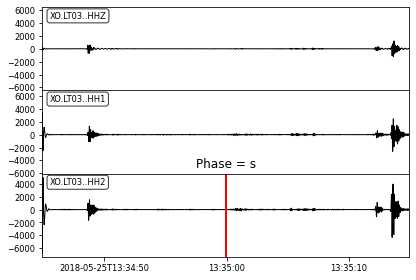

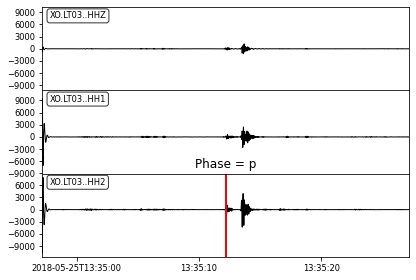

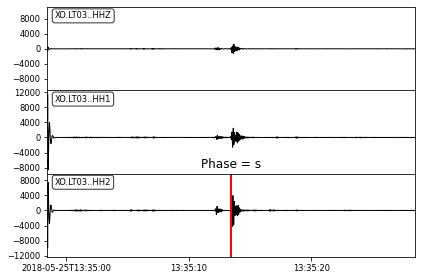

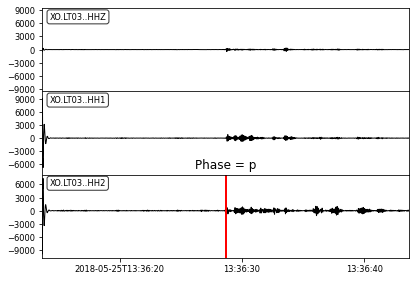

In [53]:
# Picks that PhaseNet got but aren't in the conventional catalog:
new_picks = comp[comp['og_timestamp'].isna()]
new_picks['timestamp'] = [obspy.UTCDateTime(t) for t in new_picks['timestamp']]

client = Client("iris")
interval = 30 #s
#starttime = new_picks.iloc[0].timestamp
#endtime = starttime + interval
stream = obspy.Stream()
for i in range(len(new_picks)):
    txt=new_picks.iloc[i]['id']
    trace_info=txt.split('.')
    starttime = new_picks.iloc[i].timestamp-15
    endtime = starttime + interval
    # Read in waveform:
    st = client.get_waveforms(trace_info[0],trace_info[1],trace_info[2],trace_info[3]+'*', starttime, endtime,attach_response=True)
    # Do some waveform processing:
    # st.remove_response()
    # st = st.detrend("spline", order=2, dspline=5 * st[0].stats.sampling_rate)
    # st = st.filter("highpass", freq=1.0)
    st = st.filter("bandpass",freqmin=4,freqmax=35)
    
    %matplotlib inline
    fig = plt.figure()
    st.plot(fig = fig,starttime=starttime,endtime=endtime) 
    plt.axvline(x=new_picks.iloc[i]['timestamp'],linewidth=2, color='r')
    plt.title('Phase = '+new_picks.iloc[i]['type'])
    plt.show()




Thoughts:

It is going to be hard to quantify whether these "new" picks are correct or not.

If they associate with an event that is already in the Alaska catalog, maybe we count them as good?

I think it would be good to run an entire month (or week?) of the Alaska data through QuakeFlow.

Then we could get precision, recall, and F1-score, simply to see how well QuakeFlow performed on the already existing picks.

But then it is likely we would get some new picks- how do we evaluate these?

## GOAL 2: evaluate association performance

Start by just looking at the locations of the earthquakes on a map

## TO-DO: plot both on one map

In [261]:
time = [p.origins[0].time for p in cat.events]
lat = [p.origins[0].latitude for p in cat.events]
lon = [p.origins[0].longitude for p in cat.events]
depth = [p.origins[0].depth for p in cat.events]

cat_dict = {"lat":lat,"lon":lon,"depth":depth}

cat_dict = {"lat":lat,"lon":lon,"depth":depth}
cat_df = pd.DataFrame.from_dict(cat_dict)
og_gf = gpd.GeoDataFrame(cat_df.copy(), 
                      geometry=gpd.points_from_xy(cat_df.lon, cat_df.lat),
                      crs=4326)

cat_df = pd.DataFrame.from_dict(catalog_gamma)
gf = gpd.GeoDataFrame(cat_df.copy(),geometry=gpd.points_from_xy(cat_df.longitude, cat_df.latitude),
                      crs=4326)

og_gf.explore()
# gf.explore()

## TO-DO: match up earthquakes based on timing, and for a common event, plot the two different locations but also the different stations that had arrivals - with colors based on true and false positives